# Collaborative Filtering With Pytorch

## Recommendation System

### Import necesary Libraries

In [3]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [4]:
import io
import os
import math
import copy
import pickle
import zipfile
from textwrap import wrap
from pathlib import Path
from itertools import zip_longest
from collections import defaultdict
from urllib.error import URLError
from urllib.request import urlopen

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


import torch
from torch import nn
from torch import optim
from torch.nn import functional as F 
from torch.optim.lr_scheduler import _LRScheduler

In [5]:
plt.style.use('ggplot')

In [6]:
def set_random_seed(state=1):
    gens = (np.random.seed, torch.manual_seed, torch.cuda.manual_seed)
    for set_state in gens:
        set_state(state)

In [7]:
RANDOM_STATE = 1
set_random_seed(RANDOM_STATE)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
df = pd.read_csv("/home/paul/Mindscope/Mindscope/Movie-Recomendation-System-FastAPI-React-/backend/ml-latest-small/ratings.csv")
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [10]:
df.info() # basically show schema

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [11]:
df.userId.nunique()

610

In [12]:
df.movieId.nunique()

9724

In [13]:
df.rating.value_counts() # Check value distributions

rating
4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: count, dtype: int64

In [14]:
df.shape

(100836, 4)

In [15]:
movies = pd.read_csv("/home/paul/Mindscope/Mindscope/Movie-Recomendation-System-FastAPI-React-/backend/ml-latest-small/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [16]:
def tabular_preview(ratings, n=15):
    """Creates a cross-tabular view of users vs movies."""
    
    user_groups = ratings.groupby('userId')['rating'].count()
    top_users = user_groups.sort_values(ascending=False)[:15]

    movie_groups = ratings.groupby('movieId')['rating'].count()
    top_movies = movie_groups.sort_values(ascending=False)[:15]

    top = (
        ratings.
        join(top_users, rsuffix='_r', how='inner', on='userId').
        join(top_movies, rsuffix='_r', how='inner', on='movieId'))

    return pd.crosstab(top.userId, top.movieId, top.rating, aggfunc=np.sum)

In [17]:
tabular_preview(df, movies)

/tmp/ipykernel_123780/3328232344.py:15: FutureWarning: The provided callable <function sum at 0x7f22900520e0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  return pd.crosstab(top.userId, top.movieId, top.rating, aggfunc=np.sum)


movieId,1,50,110,260,296,318,356,480,527,589,593,1196,2571,2858,2959
userId,,,,,,,,,,,,,,,
68,2.5,3.0,2.5,5.0,2.0,3.0,3.5,3.5,4.0,3.5,3.5,5.0,4.5,5.0,2.5
182,4.0,4.5,3.5,3.5,5.0,4.5,5.0,3.5,4.0,2.0,4.5,3.0,5.0,5.0,5.0
249,4.0,4.0,5.0,5.0,4.0,4.5,4.5,4.0,4.5,4.0,4.0,5.0,5.0,4.5,5.0
274,4.0,4.0,4.5,3.0,5.0,4.5,4.5,3.5,4.0,4.5,4.0,4.5,4.0,5.0,5.0
288,4.5,NaN,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,5.0,4.5,3.0,NaN,3.5
307,4.0,4.5,3.5,3.5,4.5,4.5,4.0,3.5,4.5,2.5,4.5,3.0,3.5,4.0,4.0
380,5.0,4.0,4.0,5.0,5.0,3.0,5.0,5.0,NaN,5.0,5.0,5.0,4.5,NaN,4.0
387,NaN,4.5,3.5,4.5,5.0,3.5,4.0,3.0,NaN,3.5,4.0,4.5,4.0,4.5,4.5
414,4.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0


### Dataset Preparation --------------------------------

> We need a couple of helpers to prepare the data and make it ready for the training loop. 

In [18]:
def create_dataset(df, top=None):
    if top is not None:
        df.groupby('userId')['rating'].count()
    
    unique_users = df.userId.unique()
    user_to_index = {old: new for new, old in enumerate(unique_users)}
    new_users = df.userId.map(user_to_index)
    
    unique_movies = df.movieId.unique()
    movie_to_index = {old: new for new, old in enumerate(unique_movies)}
    new_movies = df.movieId.map(movie_to_index)
    
    n_users = unique_users.shape[0]
    n_movies = unique_movies.shape[0]
    
    X = pd.DataFrame({'user_id': new_users, 'movie_id': new_movies})
    y = df['rating'].astype(np.float32)
    return (n_users, n_movies), (X, y), (user_to_index, movie_to_index)

In [19]:
(n, m), (X, y), _ = create_dataset(df)
print(f'Embeddings: {n} users, {m} movies')
print(f'Dataset shape: {X.shape}')
print(f'Target shape: {y.shape}')

Embeddings: 610 users, 9724 movies
Dataset shape: (100836, 2)
Target shape: (100836,)


In [20]:
class ReviewsIterator:
    
    def __init__(self, X, y, batch_size=32, shuffle=True):
        X, y = np.asarray(X), np.asarray(y)
        
        if shuffle:
            index = np.random.permutation(X.shape[0])
            X, y = X[index], y[index]
            
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_batches = int(math.ceil(X.shape[0] // batch_size))
        self._current = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        return self.next()
    
    def next(self):
        if self._current >= self.n_batches:
            raise StopIteration()
        k = self._current
        self._current += 1
        bs = self.batch_size
        return self.X[k*bs:(k + 1)*bs], self.y[k*bs:(k + 1)*bs]

> A convenice function batches allows us to split the dataset into smaller chunks during training/validation process:

In [21]:
def batches(X, y, bs=32, shuffle=True):
    for xb, yb in ReviewsIterator(X, y, bs, shuffle):
        xb = torch.LongTensor(xb)
        yb = torch.FloatTensor(yb)
        yield xb, yb.view(-1, 1)

In [22]:
for x_batch, y_batch in batches(X, y, bs=4):
    print(x_batch)
    print(y_batch)
    break

tensor([[ 224,  472],
        [ 532, 3638],
        [ 124, 4813],
        [ 262,  348]])
tensor([[3.],
        [5.],
        [2.],
        [5.]])


### Embeddings

> Embeddings allows us to create a network of arbirary depth, with or without dropouts. Also, the forward method accepts an additional minmax argument which is expected to be a tuple with minimum and maximum values of ratings from the dataset to normalize the predicted value into specific range.

> To create a group of hidden layers we use a generator function gen_layers that yields linear and dropout layers depending on values from hidden and dropouts arrays. We use the nn.Sequence class to group hidden layers into a single module.

In [23]:
class EmbeddingNet(nn.Module):
    """
    Creates a dense network with embedding layers.
    
    Args:
    
        n_users:            
            Number of unique users in the dataset.

        n_movies: 
            Number of unique movies in the dataset.

        n_factors: 
            Number of columns in the embeddings matrix.

        embedding_dropout: 
            Dropout rate to apply right after embeddings layer.

        hidden:
            A single integer or a list of integers defining the number of 
            units in hidden layer(s).

        dropouts: 
            A single integer or a list of integers defining the dropout 
            layers rates applyied right after each of hidden layers.
            
    """
    def __init__(self, n_users, n_movies,
                 n_factors=50, embedding_dropout=0.02, 
                 hidden=10, dropouts=0.2):
        
        super().__init__()
        hidden = get_list(hidden)
        dropouts = get_list(dropouts)
        n_last = hidden[-1]
        
        def gen_layers(n_in):
            """
            A generator that yields a sequence of hidden layers and 
            their activations/dropouts.
            
            Note that the function captures `hidden` and `dropouts` 
            values from the outer scope.
            """
            nonlocal hidden, dropouts
            assert len(dropouts) <= len(hidden)
            
            for n_out, rate in zip_longest(hidden, dropouts):
                yield nn.Linear(n_in, n_out)
                yield nn.ReLU()
                if rate is not None and rate > 0.:
                    yield nn.Dropout(rate)
                n_in = n_out
            
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.drop = nn.Dropout(embedding_dropout)
        self.hidden = nn.Sequential(*list(gen_layers(n_factors * 2)))
        self.fc = nn.Linear(n_last, 1)
        self._init()
        
    def forward(self, users, movies, minmax=None):
        features = torch.cat([self.u(users), self.m(movies)], dim=1)
        x = self.drop(features)
        x = self.hidden(x)
        out = torch.sigmoid(self.fc(x))
        if minmax is not None:
            min_rating, max_rating = minmax
            out = out*(max_rating - min_rating + 1) + min_rating - 0.5
        return out
    
    def _init(self):
        """
        Setup embeddings and hidden layers with reasonable initial values.
        """
        
        def init(m):
            if type(m) == nn.Linear:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
                
        self.u.weight.data.uniform_(-0.05, 0.05)
        self.m.weight.data.uniform_(-0.05, 0.05)
        self.hidden.apply(init)
        init(self.fc)
    
    
def get_list(n):
    if isinstance(n, (int, float)):
        return [n]
    elif hasattr(n, '__iter__'):
        return list(n)
    raise TypeError('layers configuraiton should be a single number or a list of numbers')

>If we want to create a network with a single hidden layer and dropout, we can use the following code snippet:

In [24]:
EmbeddingNet(n, m, n_factors=150, hidden=100, dropouts=0.5)

EmbeddingNet(
  (u): Embedding(610, 150)
  (m): Embedding(9724, 150)
  (drop): Dropout(p=0.02, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

In [25]:
EmbeddingNet(n, m, n_factors=150, hidden=[100, 200, 300], dropouts=[0.25, 0.5])

EmbeddingNet(
  (u): Embedding(610, 150)
  (m): Embedding(9724, 150)
  (drop): Dropout(p=0.02, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=100, out_features=200, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=200, out_features=300, bias=True)
    (7): ReLU()
  )
  (fc): Linear(in_features=300, out_features=1, bias=True)
)

### Cyclical Learning Rate (CLR)

One of the fastai library features is the cyclical learning rate scheduler. We can implement something similar inheriting the _LRScheduler class from the torch library. Following the [original paper's](https://arxiv.org/abs/1506.01186) pseudocode, this [CLR Keras callback implementation](https://github.com/bckenstler/CLR), and making a couple of adjustments to support [cosine annealing](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.CosineAnnealingLR) with restarts, let's create our own CLR scheduler.

The implementation of this idea is quite simple. The [base PyTorch scheduler class](https://pytorch.org/docs/stable/_modules/torch/optim/lr_scheduler.html) has the get_lr() method that is invoked each time when we call the step() method. The method should return a list of learning rates depending on the current training epoch. In our case, we have the same learning rate for all of the layers, and therefore, we return a list with a single value.

The next cell defines a CyclicLR class that expectes a single callback function. This function should accept the current training epoch and the base value of learning rate, and return a new learning rate value.

In [26]:
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

> Our scheduler is very similar to LambdaLR one but expects a bit different callback signature.

> So now we only need to define appropriate scheduling functions. We're createing a couple of functions that accept scheduling parameters and return a new function with the appropriate signature:


In [27]:
def triangular(step_size, max_lr, method='triangular', gamma=0.99):
    
    def scheduler(epoch, base_lr):
        period = 2 * step_size
        cycle = math.floor(1 + epoch/period)
        x = abs(epoch/step_size - 2*cycle + 1)
        delta = (max_lr - base_lr)*max(0, (1 - x))

        if method == 'triangular':
            pass  # we've already done
        elif method == 'triangular2':
            delta /= float(2 ** (cycle - 1))
        elif method == 'exp_range':
            delta *= (gamma**epoch)
        else:
            raise ValueError('unexpected method: %s' % method)
            
        return base_lr + delta
        
    return scheduler

In [28]:
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + math.cos(math.pi*t/t_max))/2
    
    return scheduler

> To understand how the created functions work, and to check the correctness of our implementation, let's create a couple of plots visualizing learning rates changes depending on the number of epoch:

In [29]:
def plot_lr(schedule):
    ts = list(range(1000))
    y = [schedule(t, 0.001) for t in ts]
    plt.plot(ts, y)

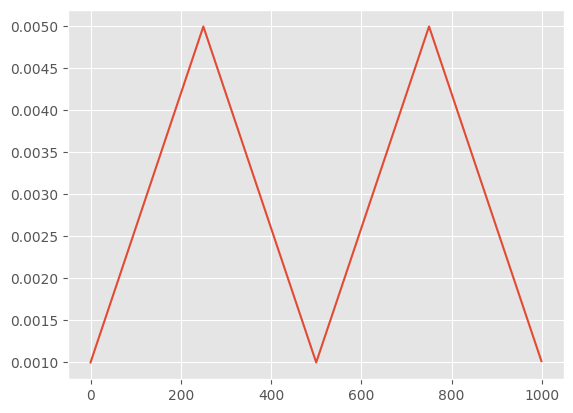

In [30]:
plot_lr(triangular(250, 0.005))

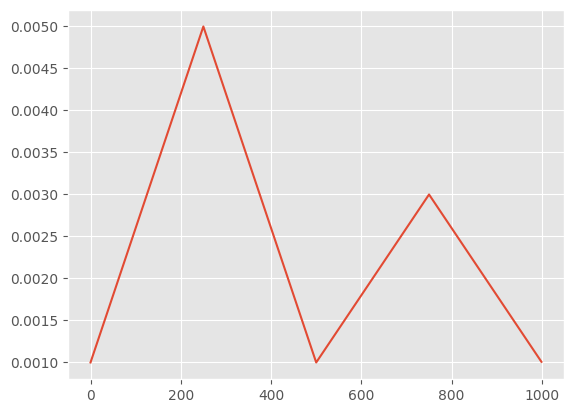

In [31]:
plot_lr(triangular(250, 0.005, 'triangular2'))

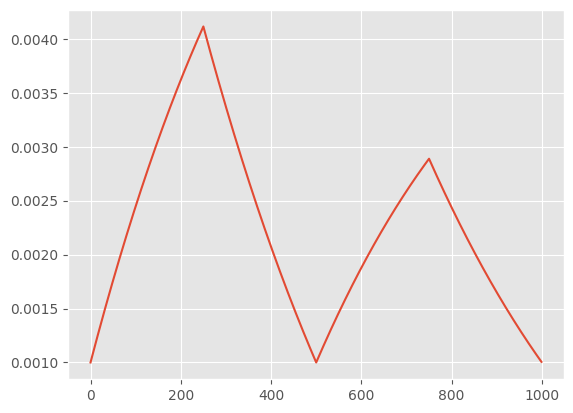

In [32]:
plot_lr(triangular(250, 0.005, 'exp_range', gamma=0.999))

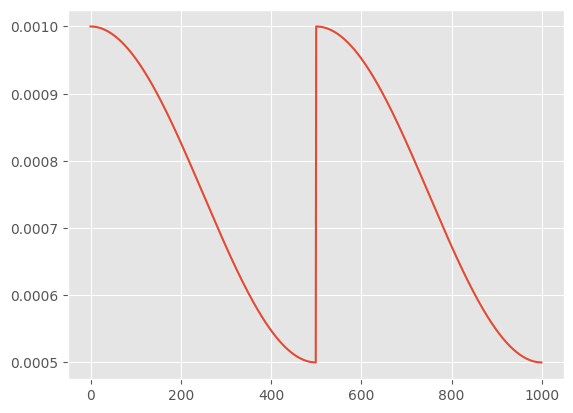

In [33]:
plot_lr(cosine(t_max=500, eta_min=0.0005))

> Note that cosine annealing scheduler is a bit different from other schedules as soon as it starts with base_lr and gradually decreases it to the minimal value while triangle schedulers increase the original rate.


-------------------------------------------------------------------

### Training Loop

> Now we're ready to start the training process. First of all, let's split the original dataset using train_test_split function from the scikit-learn library. (Though you can use anything else instead, like, [get_cv_idxs](https://github.com/fastai/fastai/blob/921777feb46f215ed2b5f5dcfcf3e6edd299ea92/fastai/dataset.py#L6-L22) from fastai).

In [34]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
datasets = {'train': (X_train, y_train), 'val': (X_valid, y_valid)}
dataset_sizes = {'train': len(X_train), 'val': len(X_valid)}

In [35]:
minmax = df.rating.min().astype(float), df.rating.max().astype(float)
minmax

(0.5, 5.0)

In [36]:
net = EmbeddingNet(
    n_users=n, n_movies=m, 
    n_factors=150, hidden=[500, 500, 500], 
    embedding_dropout=0.05, dropouts=[0.5, 0.5, 0.25])

> The next cell is preparing and running the training loop with cyclical learning rate, validation and early stopping. We use Adam optimizer with cosine-annealing learnign rate. The rate is decreased on each batch during 2 epochs, and then is reset to the original value.

> Note that our loop has two phases. One of them is called train. During this phase, we update our network's weights and change the learning rate. The another one is called val and is used to check the model's performence. When the loss value decreases, we save model parameters to restore them later. If there is no improvements after 10 sequential training epochs, we exit from the loop.


In [37]:
lr = 1e-3
wd = 1e-5
bs = 2000 
n_epochs = 300
patience = 10
no_improvements = 0
best_loss = np.inf
best_weights = None
history = []
lr_history = []

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
iterations_per_epoch = int(math.ceil(dataset_sizes['train'] // bs))
scheduler = CyclicLR(optimizer, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/10))

for epoch in range(n_epochs):
    stats = {'epoch': epoch + 1, 'total': n_epochs}
    
    for phase in ('train', 'val'):
        training = phase == 'train'
        running_loss = 0.0
        n_batches = 0
        batch_num = 0
        for batch in batches(*datasets[phase], shuffle=training, bs=bs):
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()
            # compute gradients only during 'train' phase
            with torch.set_grad_enabled(training):
                outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
                loss = criterion(outputs, y_batch)
                
                # don't update weights and rates when in 'val' phase
                if training:
                    scheduler.step()
                    loss.backward()
                    optimizer.step()
                    lr_history.extend(scheduler.get_lr())
                    
            running_loss += loss.item()
            
        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss
        
        # early stopping: save weights of the best model so far
        if phase == 'val':
            if epoch_loss < best_loss:
                print('loss improvement on epoch: %d' % (epoch + 1))
                best_loss = epoch_loss
                best_weights = copy.deepcopy(net.state_dict())
                no_improvements = 0
            else:
                no_improvements += 1
                
    history.append(stats)
    print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
    if no_improvements >= patience:
        print('early stopping after epoch {epoch:03d}'.format(**stats))
        break

/home/paul/Mindscope/Mindscope/Movie-Recomendation-System-FastAPI-React-/backend/venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


loss improvement on epoch: 1
[001/300] train: 0.9977 - val: 0.8613
loss improvement on epoch: 2
[002/300] train: 0.7709 - val: 0.8211
loss improvement on epoch: 3
[003/300] train: 0.7238 - val: 0.7831
[004/300] train: 0.6519 - val: 0.7882
loss improvement on epoch: 5
[005/300] train: 0.6572 - val: 0.7720
[006/300] train: 0.6136 - val: 0.7775
[007/300] train: 0.6202 - val: 0.7774
[008/300] train: 0.5793 - val: 0.7937
[009/300] train: 0.5870 - val: 0.7898
[010/300] train: 0.5431 - val: 0.8011
[011/300] train: 0.5439 - val: 0.8149
[012/300] train: 0.4871 - val: 0.8261
[013/300] train: 0.4845 - val: 0.8461
[014/300] train: 0.4243 - val: 0.8619
[015/300] train: 0.4189 - val: 0.8736
early stopping after epoch 015


### Metrics

> To visualize the training process and to check the correctness of the learning rate scheduling, let's create a couple of plots using collected stats:

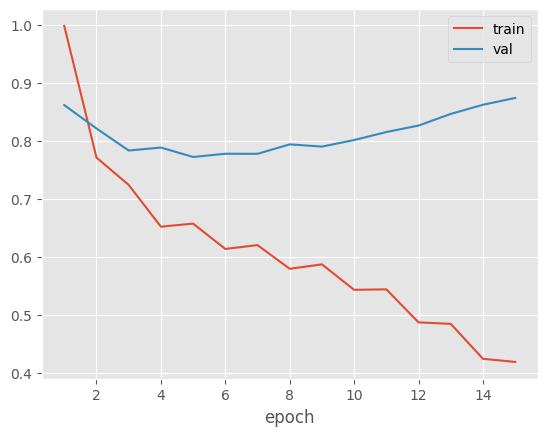

In [38]:
ax = pd.DataFrame(history).drop(columns='total').plot(x='epoch')

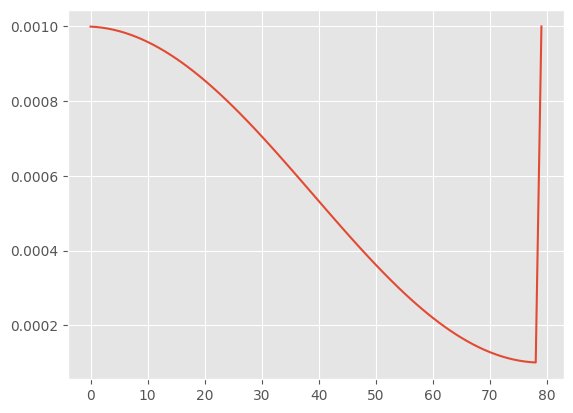

In [39]:
_ = plt.plot(lr_history[:2*iterations_per_epoch])

> As expected, the learning rate is updated in accordance with cosine annealing schedule.

> The training process was terminated after 16 epochs. Now we're going to restore the best weights saved during training, and apply the model to the validation subset of the data to see the final model's performance:


In [40]:
net.load_state_dict(best_weights)

<All keys matched successfully>

In [41]:
groud_truth, predictions = [], []

with torch.no_grad():
    for batch in batches(*datasets['val'], shuffle=False, bs=bs):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
        groud_truth.extend(y_batch.tolist())
        predictions.extend(outputs.tolist())

groud_truth = np.asarray(groud_truth).ravel()
predictions = np.asarray(predictions).ravel()

In [42]:
final_loss = np.sqrt(np.mean((np.array(predictions) - np.array(groud_truth))**2))
print(f'Final RMSE: {final_loss:.4f}')

Final RMSE: 0.8810


In [43]:
np.array(predictions)

array([2.61938095, 3.35187125, 2.1540029 , ..., 3.444695  , 2.15021992,
       2.5394609 ])

In [44]:
with open('models/best.weights', 'wb') as file:
    pickle.dump(best_weights, file)

FileNotFoundError: [Errno 2] No such file or directory: 'models/best.weights'